In [1]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import MaxPooling2D, BatchNormalization
from keras.applications import MobileNet, VGG16, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
train_folder = "Data/train"
valid_folder = "Data/valid"
test_folder = "Data/test"


In [3]:
input_shape = (224,224)
num_class = 4

train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)
val_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
)
test_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=input_shape,
    batch_size=32,
    class_mode='categorical',
)


test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=input_shape,
    batch_size=32,
    class_mode='categorical',
    shuffle = False,
)
validation_generator = val_datagen.flow_from_directory(
    valid_folder,
    target_size=input_shape,
    batch_size=32,
    class_mode='categorical',
)

Found 616 images belonging to 4 classes.


Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [4]:
modelVGG16 = VGG16(
    input_shape=(224,224,3),
    weights = 'imagenet',
    include_top = False,
)

for layer in modelVGG16.layers:
    layer.trainable = False

In [5]:
model = Sequential([
    modelVGG16,
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(.3),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dropout(.3),
    Dense(512, activation = 'relu'),
    Dropout(.3),
    Dense(256, activation = 'relu'),
    Dropout(.3),
    Dense(num_class, activation = 'softmax')
])


print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 512)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 3, 512)         0         
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1024)              4

In [6]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(loss = 'categorical_crossentropy',
             optimizer = opt,
             metrics = ['accuracy'])


In [31]:
epochs = 50

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1
)

Epoch 1/50
20/20 [==============================] - 137s 7s/step - loss: 2.0755 - accuracy: 0.4140 - val_loss: 2.3634 - val_accuracy: 0.4722
Epoch 2/50
20/20 [==============================] - 131s 7s/step - loss: 1.3229 - accuracy: 0.5357 - val_loss: 1.0574 - val_accuracy: 0.4861
Epoch 3/50
20/20 [==============================] - 126s 6s/step - loss: 1.0553 - accuracy: 0.5666 - val_loss: 0.7221 - val_accuracy: 0.6528
Epoch 4/50
20/20 [==============================] - 126s 6s/step - loss: 0.9190 - accuracy: 0.6039 - val_loss: 0.8522 - val_accuracy: 0.6389
Epoch 5/50
20/20 [==============================] - 125s 6s/step - loss: 0.9303 - accuracy: 0.6055 - val_loss: 0.7003 - val_accuracy: 0.6667
Epoch 6/50
20/20 [==============================] - 124s 6s/step - loss: 0.8243 - accuracy: 0.6721 - val_loss: 0.7263 - val_accuracy: 0.6667
Epoch 7/50
20/20 [==============================] - 124s 6s/step - loss: 0.6891 - accuracy: 0.7127 - val_loss: 0.5715 - val_accuracy: 0.7917
Epoch 8/50
20

In [32]:
test = test_generator
score = model.evaluate(test, verbose = 1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

10/10 [==============================] - 58s 6s/step - loss: 0.2796 - accuracy: 0.9079
Test loss: 0.27959775924682617
Test accuracy: 0.9079365134239197


In [33]:
num_test_samples = len(test_generator)
num_classes = len(test_generator.class_indices)

predicted_probabilities = model.predict(test_generator, steps=num_test_samples)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

true_labels = test_generator.classes

report = classification_report(true_labels, predicted_labels)

print(report)


10/10 [==============================] - 60s 6s/step
              precision    recall  f1-score   support

           0       0.97      0.81      0.88       120
           1       0.77      1.00      0.87        51
           2       1.00      0.98      0.99        54
           3       0.89      0.94      0.91        90

    accuracy                           0.91       315
   macro avg       0.91      0.93      0.91       315
weighted avg       0.92      0.91      0.91       315



In [43]:
import numpy as np
from keras.utils import load_img,img_to_array

test_image = load_img(r'Data\test\adenocarcinoma\000122 (4).png',target_size=(224,224))
test_image = img_to_array(test_image)
#test_image = test_image/255.
test_image = np.expand_dims(test_image,axis=0)
result = model.predict(test_image)
args = train_generator.class_indices
print(args)
print(result)
print([k for k,v in args.items() if v == np.argmax(result)][0])

1/1 [==============================] - 0s 236ms/step
{'adenocarcinoma': 0, 'large.cell.carcinoma': 1, 'normal': 2, 'squamous.cell.carcinoma': 3}
[[9.9645799e-01 1.9773815e-03 4.3132415e-05 1.5214476e-03]]
adenocarcinoma


In [35]:
model.save("best_model_50_epochs.h5")

In [4]:
from keras.models import load_model

best_model = load_model("best_model_50_epochs.h5")

In [37]:
score = best_model.evaluate(test_generator, verbose = 1)

10/10 [==============================] - 58s 6s/step - loss: 0.2796 - accuracy: 0.9079


In [38]:
import numpy as np
from keras.utils import load_img,img_to_array

test_image = load_img(r'Data\test\squamous.cell.carcinoma\000122.png',target_size=(224,224))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)
result = best_model.predict(test_image)
args = train_generator.class_indices
print(args)
print(result)
print([k for k,v in args.items() if v == np.argmax(result)][0])

1/1 [==============================] - 0s 401ms/step
{'adenocarcinoma': 0, 'large.cell.carcinoma': 1, 'normal': 2, 'squamous.cell.carcinoma': 3}
[[1.3326726e-05 5.7316242e-07 2.6648022e-09 9.9998605e-01]]
squamous.cell.carcinoma


In [42]:
test_image = load_img(r'Data\test\large.cell.carcinoma\000154.png',target_size=(224,224))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)
result = best_model.predict(test_image)
args = train_generator.class_indices
print(args)
print(result)
print([k for k,v in args.items() if v == np.argmax(result)][0])

1/1 [==============================] - 0s 181ms/step
{'adenocarcinoma': 0, 'large.cell.carcinoma': 1, 'normal': 2, 'squamous.cell.carcinoma': 3}
[[1.8946163e-02 9.7987133e-01 3.1221050e-05 1.1512522e-03]]
large.cell.carcinoma


In [44]:
test_image = load_img(r'Data\test\normal\8.png',target_size=(224,224))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)
result = best_model.predict(test_image)
args = train_generator.class_indices
print(args)
print(result)
print([k for k,v in args.items() if v == np.argmax(result)][0])

1/1 [==============================] - 0s 212ms/step
{'adenocarcinoma': 0, 'large.cell.carcinoma': 1, 'normal': 2, 'squamous.cell.carcinoma': 3}
[[5.2199786e-21 1.2506744e-29 1.0000000e+00 6.8205407e-27]]
normal


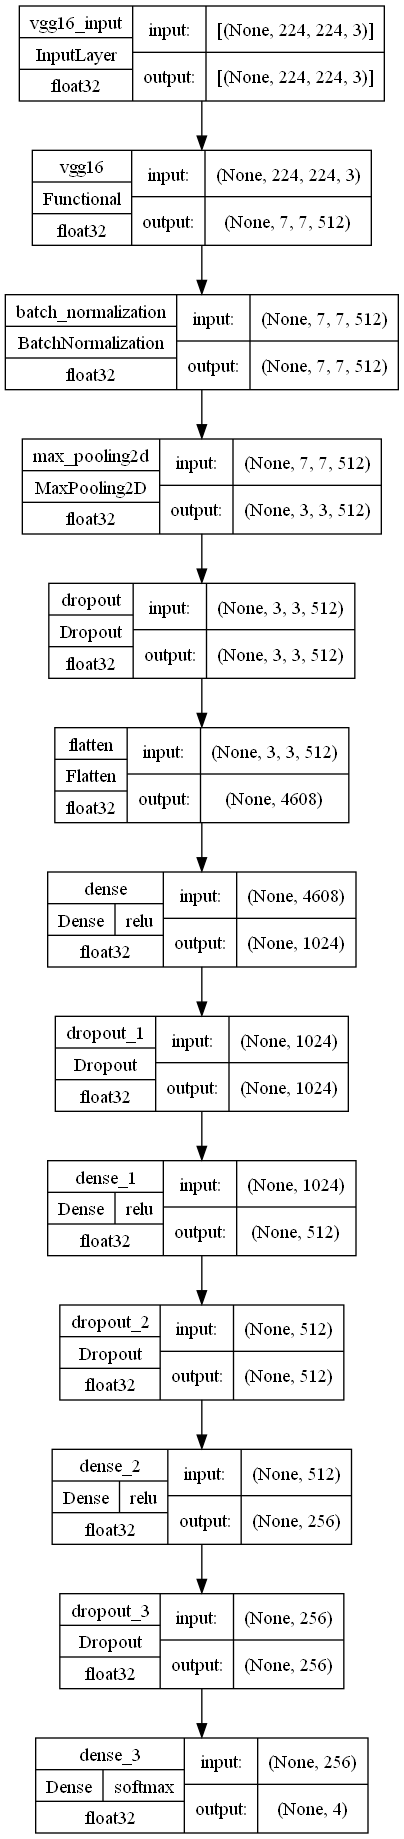

In [7]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    #show_trainable=False,
)